#  ***Digit Recognizer (Multiclassification Problem)***

# import libraries

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models, transforms
import matplotlib.pyplot as plt
import time
import copy
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

# Setting up the Dataset


In [2]:
train_df=pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test_df=pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
sample_df=pd.read_csv("/kaggle/input/digit-recognizer/sample_submission.csv")

In [3]:
def prepare_data(dataset ,case):
    if (case == 'train'):
        raw_train_labels = dataset["label"]
        raw_train_imgs = dataset.iloc[:, 1:]
        normalized_train = raw_train_imgs/255.0
        return normalized_train,raw_train_labels
    elif (case == 'test'):
        normalized_test= dataset/255.0
        test_data = torch.from_numpy(normalized_test.values.reshape((-1,1,28,28)))
        return test_data
    

def split_data_and_reshape_it(normalized_train,raw_train_labels):
    train_split, validation_split, train_labels_split, validation_labels_split = train_test_split(normalized_train, raw_train_labels, random_state=0)
    train_data = torch.from_numpy(train_split.values.reshape((-1,1,28,28)))
    train_labels_data =  torch.from_numpy(train_labels_split.values)
    validation_data = torch.from_numpy(validation_split.values.reshape((-1,1,28,28)))
    validation_labels_data =  torch.from_numpy(validation_labels_split.values)
    return train_data ,train_labels_data ,validation_data ,validation_labels_data    

In [4]:
normalized_train,raw_train_labels=prepare_data(train_df ,case='train')
test_data=prepare_data(test_df ,case='test')
train_data ,train_labels_data ,validation_data ,validation_labels_data=split_data_and_reshape_it(normalized_train,raw_train_labels)

In [5]:
# define custom dataset
class MyDataset(Dataset):
    def __init__(self, feature, target=None, transform=None):

        self.X = feature
        self.Y = target
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.transform is not None:
            return self.transform(self.X[idx]), self.Y[idx]
        elif self.Y is None:
            return [self.X[idx]]
        return self.X[idx], self.Y[idx]

In [6]:
train_set = MyDataset(train_data.float(), train_labels_data)
valid_set = MyDataset(validation_data.float(), validation_labels_data)
test_set = MyDataset(test_data.float())
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = False)

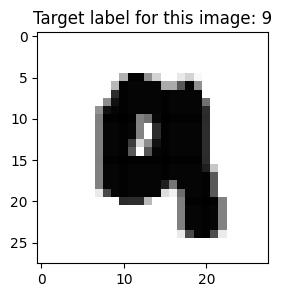

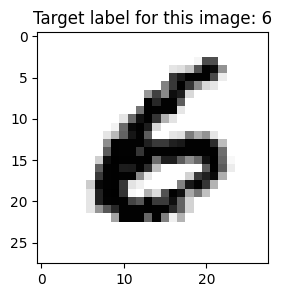

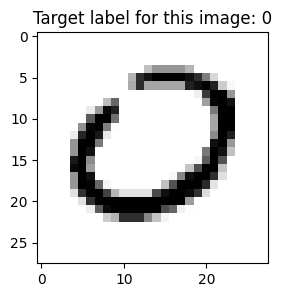

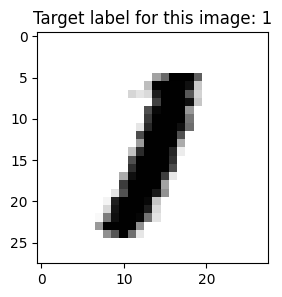

In [7]:
for i in range(42,46):
    image_label = 42
    plt.figure(figsize=(3, 3))
    plt.imshow(train_data[i].reshape(28, 28), cmap="binary")
    plt.title(f'Target label for this image: {train_labels_data[i]}')
    plt.show()

<Axes: title={'center': 'Count'}, xlabel='Label', ylabel='Frequency'>

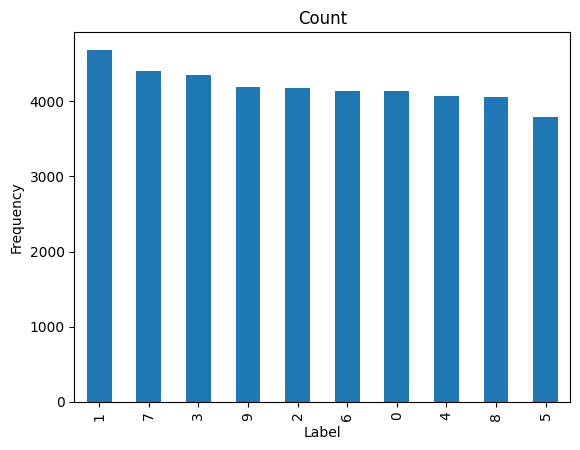

In [8]:
# Distribution
train_df.label.value_counts().plot(
    kind="bar", title="Count", ylabel="Frequency", xlabel="Label"
)

# Data_augmentation

In [9]:
# calculate mean and std of train_set for normalize
data = next(iter(train_loader))
mean = data[0].mean()
std = data[0].std()

# set transformation option
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomAffine(degrees = 30),
        transforms.RandomPerspective(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)])

# augmented train_set
augmented_train_set = MyDataset(train_data.float(), train_labels_data, transform=transform)

# combine original set with augmented set
datasets = []
datasets.append(train_set)
datasets.append(augmented_train_set)
train_set = torch.utils.data.ConcatDataset(datasets)

# redefine train_loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)

# Model

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataloaders = {'train': train_loader, 'val': valid_loader}
dataset_sizes= {'train': len(train_set), 'val': len(valid_set)}

def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
               phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        #print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model

In [11]:
epochs = 50

# make resnet 18 model
model_ft = models.resnext50_32x4d(pretrained=False)

# change input layer
# the default number of input channel in the resnet is 3, but our images are 1 channel. So we have to change 3 to 1.
# nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) <- default
model_ft.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) 

# change fc layer
# the number of classes in our dataset is 10. default is 1000.
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

# train model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, dataset_sizes,num_epochs=epochs)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 0/49
----------
train Loss: 0.5623 Acc: 0.8219
val Loss: 0.1105 Acc: 0.9681
Epoch 1/49
----------
train Loss: 0.2098 Acc: 0.9363
val Loss: 0.0758 Acc: 0.9774
Epoch 2/49
----------
train Loss: 0.1582 Acc: 0.9527
val Loss: 0.0504 Acc: 0.9854
Epoch 3/49
----------
train Loss: 0.1202 Acc: 0.9639
val Loss: 0.0617 Acc: 0.9820
Epoch 4/49
----------
train Loss: 0.1210 Acc: 0.9643
val Loss: 0.0507 Acc: 0.9846
Epoch 5/49
----------
train Loss: 0.0717 Acc: 0.9776
val Loss: 0.0272 Acc: 0.9920
Epoch 6/49
----------
train Loss: 0.0585 Acc: 0.9815
val Loss: 0.0250 Acc: 0.9930
Epoch 7/49
----------
train Loss: 0.0519 Acc: 0.9837
val Loss: 0.0225 Acc: 0.9936
Epoch 8/49
----------
train Loss: 0.0495 Acc: 0.9852
val Loss: 0.0241 Acc: 0.9925
Epoch 9/49
----------
train Loss: 0.0458 Acc: 0.9857
val Loss: 0.0246 Acc: 0.9922
Epoch 10/49
----------
train Loss: 0.0418 Acc: 0.9873
val Loss: 0.0219 Acc: 0.9935
Epoch 11/49
----------
train Loss: 0.0389 Acc: 0.9881
val Loss: 0.0215 Acc: 0.9936
Epoch 12/49
--

In [14]:
test_pred = torch.LongTensor()

with torch.no_grad():
    for images in test_loader:
        images = torch.autograd.Variable(images[0])
        if torch.cuda.is_available():
            images = images.to(device)

        outputs = model_ft(images)
        predicted = outputs.cpu().data.max(1, keepdim=True)[1]
        test_pred = torch.cat((test_pred, predicted), dim=0)

In [15]:
import numpy as np 
out_df = pd.DataFrame(np.c_[np.arange(1, len(test_set)+1)[:,None], test_pred.numpy()],
                      columns=['ImageId', 'Label'])
out_df.to_csv('submission.csv', index=False)
